# Env

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

from pathlib import Path
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

import scipy.stats as stats

# Data Processing

In [2]:
root = Path("./target/okx_btcusdt_features_0.1_10_5_+p")

all_files = root.rglob("*.parquet")
all_files = sorted(list(all_files))[:1]

books = pd.read_parquet(all_files)

books.loc[books.vwap == -1, 'vwap'] = np.nan
books = books.ffill().dropna(how='any')

In [3]:
n = 10**10
bs = books.iloc[:n, :].drop('iso_time', axis=1).set_index('timestamp', drop=True)
n, k = bs.shape

In [4]:
n, k

(863996, 43)

In [5]:
bs.head()

,vwap,buy_volume,sell_volume,ask_size_1,ask_size_2,ask_size_3,ask_size_4,ask_size_5,ask_size_6,ask_size_7,...,bid_price_1,bid_price_2,bid_price_3,bid_price_4,bid_price_5,bid_price_6,bid_price_7,bid_price_8,bid_price_9,bid_price_10
timestamp,,,,,,,,,,,,,,,,,,,,,
1759276800500,114046.528629,0.000000,0.000086,1.220644,0.000279,0.001537,0.034207,0.000042,0.000100,0.000010,...,114047.1,114047.0,114046.2,114046.0,114045.4,114045.2,114045.0,114044.9,114044.4,114044.2
1759276800600,114047.154241,0.001078,0.000000,1.219741,0.000279,0.001537,0.034207,0.000042,0.000100,0.000010,...,114047.1,114047.0,114046.2,114046.0,114045.4,114045.2,114045.1,114045.0,114044.9,114044.4
1759276800700,114047.154241,0.000000,0.000000,1.201651,0.000279,0.001537,0.034207,0.000042,0.000100,0.000010,...,114047.1,114047.0,114046.2,114046.0,114045.4,114045.2,114045.1,114045.0,114044.9,114044.4
1759276800800,114047.154241,0.000000,0.000000,1.201651,0.000279,0.001537,0.034207,0.000042,0.000100,0.000010,...,114047.1,114047.0,114046.2,114046.0,114045.4,114045.2,114045.1,114045.0,114044.9,114044.4
1759276800900,114048.829910,1.716061,0.000000,0.000534,0.000060,0.001807,0.002000,0.105577,0.000085,0.000654,...,114054.8,114053.2,114052.7,114052.6,114052.5,114052.0,114051.9,114051.7,114051.4,114051.3


### Target

In [6]:
rt1 = np.log(bs.vwap).diff(1)
rt10 = np.log(bs.vwap).diff(10)

<Axes: >

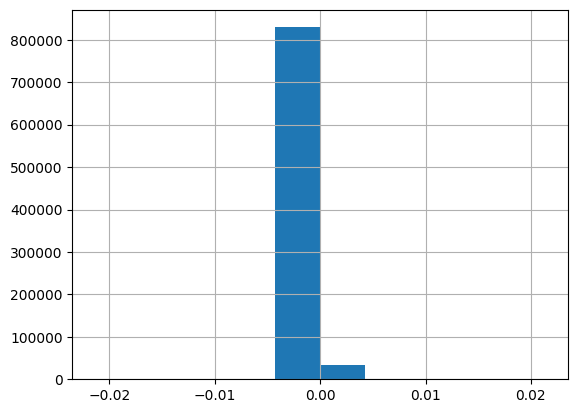

In [7]:
rt1.hist()

<Axes: >

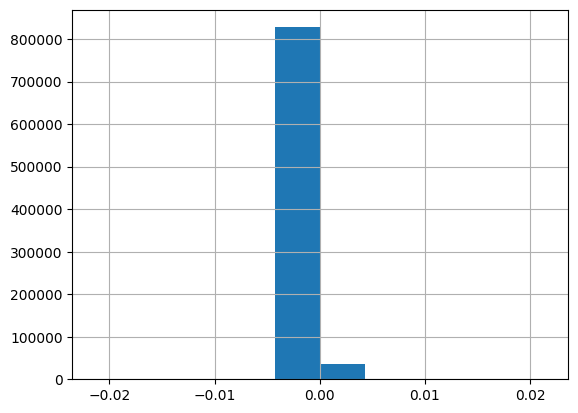

In [8]:
rt10.hist()

In [9]:
rt1.isna().sum()

np.int64(1)

In [10]:
rt10.isna().sum()

np.int64(10)

# EDA

#### Utils

In [11]:
def q_trunc(series: pd.Series, low=1e-4, high=1-1e-4):
  return series.clip(series.quantile(low), series.quantile(high))

def t_corr(series, shift=-1):
  return series.corr(series.shift(shift))

def fit_linear(series):
    x = np.arange(len(series))
    y = series.values

    a, b = np.polyfit(x, y, deg=1)

    y_fit = a * x + b

    return a, b, y_fit

def show_simple_autocorr(series, max_lag=10, step=1):
    print("Simple autocorrelation (Pearson) by lag:")
    for k in range(1, max_lag + 1):
        print(f"lag {k:2d}: {series.autocorr(lag=k*step): .4f}")


def plot_auto(series, lags=10):
    max_lag = 10

    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    plot_acf(series, lags=lags, ax=axes[0])
    axes[0].set_title("ACF")

    plot_pacf(series, lags=lags, ax=axes[1], method="ywm")
    axes[1].set_title("PACF")

    plt.tight_layout()
    plt.show()

def plot_auto_shift(series, lags=40, shift=1):
    acf_vals = acf(series, nlags=lags)[shift:]      # remove lag 0
    pacf_vals = pacf(series, nlags=lags)[shift:]    # remove lag 0

    lags = range(shift, lags + 1)

    fig, ax = plt.subplots(2, 1, figsize=(10, 6))

    ax[0].stem(lags, acf_vals)
    ax[0].set_title("ACF (lag 1 to nlags)")

    ax[1].stem(lags, pacf_vals)
    ax[1].set_title("PACF (lag 1 to nlags)")

    plt.tight_layout()
    plt.show()


def acf_rolling(series: pd.Series, lag=1, window=20000, step=None):
  if step is None:
    step = window

  autos = np.zeros(int((len(series) - window) / step) + 1)

  for i in range(0, len(series) - window, step):
    autos[int(i / step)] = series[i:i+window].autocorr(lag)

  return pd.Series(autos)

def moment_rolling(series: pd.Series, order=1, window=20000, step=None):
  if step is None:
    step = window

  m = np.zeros(int((len(series) - window) / step) + 1)
  for i in range(0, len(series) - window, step):
    m[i//step] = stats.moment(series[i:i+window], order=order)

  return pd.Series(m)


#### General

In [ ]:
n, k = bs.shape
print(n, k)

863996 43


In [ ]:
bs.head()

,vwap,buy_volume,sell_volume,ask_size_1,ask_size_2,ask_size_3,ask_size_4,ask_size_5,ask_size_6,ask_size_7,...,bid_price_1,bid_price_2,bid_price_3,bid_price_4,bid_price_5,bid_price_6,bid_price_7,bid_price_8,bid_price_9,bid_price_10
timestamp,,,,,,,,,,,,,,,,,,,,,
1759276800500,114046.528629,0.000000,0.000086,1.220644,0.000279,0.001537,0.034207,0.000042,0.000100,0.000010,...,114047.1,114047.0,114046.2,114046.0,114045.4,114045.2,114045.0,114044.9,114044.4,114044.2
1759276800600,114047.154241,0.001078,0.000000,1.219741,0.000279,0.001537,0.034207,0.000042,0.000100,0.000010,...,114047.1,114047.0,114046.2,114046.0,114045.4,114045.2,114045.1,114045.0,114044.9,114044.4
1759276800700,114047.154241,0.000000,0.000000,1.201651,0.000279,0.001537,0.034207,0.000042,0.000100,0.000010,...,114047.1,114047.0,114046.2,114046.0,114045.4,114045.2,114045.1,114045.0,114044.9,114044.4
1759276800800,114047.154241,0.000000,0.000000,1.201651,0.000279,0.001537,0.034207,0.000042,0.000100,0.000010,...,114047.1,114047.0,114046.2,114046.0,114045.4,114045.2,114045.1,114045.0,114044.9,114044.4
1759276800900,114048.829910,1.716061,0.000000,0.000534,0.000060,0.001807,0.002000,0.105577,0.000085,0.000654,...,114054.8,114053.2,114052.7,114052.6,114052.5,114052.0,114051.9,114051.7,114051.4,114051.3


In [ ]:
bs.tail()

,vwap,buy_volume,sell_volume,ask_size_1,ask_size_2,ask_size_3,ask_size_4,ask_size_5,ask_size_6,ask_size_7,...,bid_price_1,bid_price_2,bid_price_3,bid_price_4,bid_price_5,bid_price_6,bid_price_7,bid_price_8,bid_price_9,bid_price_10
timestamp,,,,,,,,,,,,,,,,,,,,,
1759363199600,118607.630922,0.0,0.0,0.396941,0.000011,0.010189,0.03362,0.11,0.036676,0.042684,...,118607.6,118607.0,118606.0,118605.6,118605.1,118605.0,118604.5,118604.0,118603.7,118603.0
1759363199700,118607.630922,0.0,0.0,0.396941,0.000011,0.010189,0.03362,0.11,0.036676,0.042684,...,118607.6,118607.0,118606.0,118605.6,118605.1,118605.0,118604.5,118604.0,118603.7,118603.0
1759363199800,118607.630922,0.0,0.0,0.286941,0.000011,0.010189,0.03362,0.11,0.036676,0.042684,...,118607.6,118607.0,118606.0,118605.7,118605.6,118605.0,118604.5,118604.0,118603.7,118603.0
1759363199900,118607.630922,0.0,0.0,0.295373,0.000011,0.010189,0.03362,0.11,0.036676,0.042684,...,118607.6,118607.0,118606.0,118605.7,118605.6,118605.0,118604.5,118604.0,118603.7,118603.0
1759363200000,118607.630922,0.0,0.0,0.473635,0.000011,0.010189,0.03362,0.11,0.036676,0.042684,...,118607.6,118605.7,118605.6,118605.0,118604.5,118604.0,118603.7,118603.0,118601.7,118601.0


In [ ]:
bs.describe()

,vwap,buy_volume,sell_volume,ask_size_1,ask_size_2,ask_size_3,ask_size_4,ask_size_5,ask_size_6,ask_size_7,...,bid_price_1,bid_price_2,bid_price_3,bid_price_4,bid_price_5,bid_price_6,bid_price_7,bid_price_8,bid_price_9,bid_price_10
count,863996.000000,863996.000000,863996.000000,8.639960e+05,8.639960e+05,863996.000000,863996.000000,863996.000000,863996.000000,863996.000000,...,863996.000000,863996.000000,863996.000000,863996.000000,863996.000000,863996.000000,863996.000000,863996.000000,863996.000000,863996.000000
mean,116142.631876,0.003907,0.003742,7.260442e-01,7.700146e-02,0.074186,0.077678,0.072028,0.065737,0.066129,...,116143.665037,116143.145159,116142.629456,116142.129902,116141.639466,116141.136817,116140.637303,116140.138645,116139.650429,116139.174076
std,1383.198571,0.137168,0.098832,9.228540e-01,2.975365e-01,0.282807,0.601221,0.514535,0.329386,0.569842,...,1383.191113,1383.139237,1383.135577,1383.133961,1383.135998,1383.133243,1383.125205,1383.110182,1383.096711,1383.083773
min,113953.747659,0.000000,0.000000,1.000000e-07,1.300000e-07,0.000007,0.000003,0.000010,0.000007,0.000007,...,113955.400000,113955.000000,113954.900000,113954.600000,113954.500000,113954.300000,113954.000000,113953.900000,113953.200000,113953.000000
25%,114515.822403,0.000000,0.000000,1.763485e-01,4.632990e-03,0.004250,0.001867,0.001807,0.001701,0.001000,...,114516.100000,114516.000000,114515.600000,114515.200000,114515.000000,114514.600000,114514.000000,114513.400000,114512.900000,114512.275000
50%,116483.099817,0.000000,0.000000,5.648731e-01,2.160000e-02,0.021600,0.021600,0.021600,0.017300,0.016466,...,116484.600000,116484.000000,116482.900000,116482.700000,116482.100000,116481.500000,116481.100000,116480.900000,116480.700000,116480.400000
75%,117374.434514,0.000000,0.000000,1.066274e+00,5.340510e-02,0.062105,0.064250,0.056077,0.043577,0.043100,...,117375.500000,117375.100000,117374.700000,117374.000000,117373.900000,117373.600000,117372.700000,117372.000000,117371.600000,117371.000000
max,118655.597201,32.225204,30.240793,1.322753e+02,7.007805e+01,52.653417,71.902907,52.118938,70.079048,146.105127,...,118655.600000,118655.200000,118655.000000,118654.900000,118654.600000,118654.000000,118653.600000,118652.000000,118651.700000,118651.000000


#### Returns

In [15]:
n

863996

In [35]:
rt1 = rt1.fillna(0)
rt10 = rt10.fillna(0)

In [ ]:
# rt1_c = rt1 - rt1.mean()
# rt10_c = rt10 - rt10.mean()

In [36]:
rt1_trunc = q_trunc(rt1)
# rt1_trunc = rt1_trunc - rt1_trunc.mean()
rt10_trunc = q_trunc(rt10)
# rt10_trunc = rt10_trunc - rt10_trunc.mean()

In [39]:
rt1_trunc.to_csv("rt1_trunc.csv")
rt10_trunc.to_csv("rt10_trunc.csv")

In [37]:
print(rt1_trunc.skew(), rt1_trunc.kurtosis())
print(rt10_trunc.skew(), rt10_trunc.kurt())

0.0936646803592336 51.74039462127351
0.5160195703368116 29.083273005411904


In [38]:
print(t_corr(rt1_trunc), t_corr(rt10_trunc, -10))

0.08359504555737553 0.10650135870829712


<Axes: >

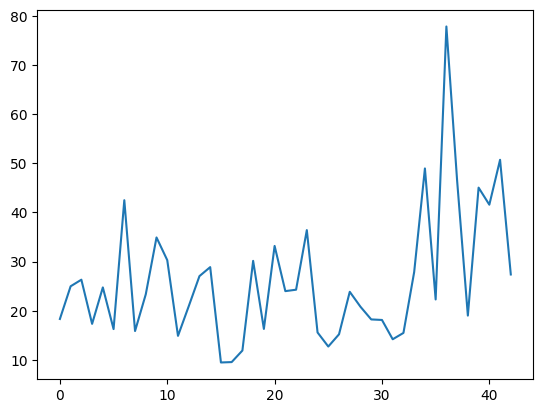

In [23]:
kurts = moment_rolling(rt10_trunc.fillna(0), order=4)
stds = moment_rolling(rt10_trunc.fillna(0), order=2)
(kurts/stds.pow(2)).plot()

<Axes: >

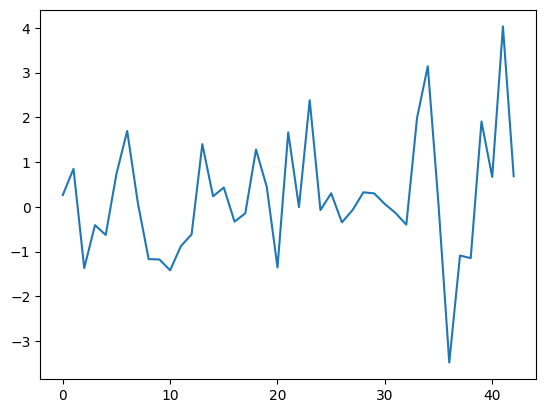

In [24]:
skews = moment_rolling(rt10_trunc.fillna(0), order=3)
(skews/stds.pow(1.5)).plot()

<Axes: >

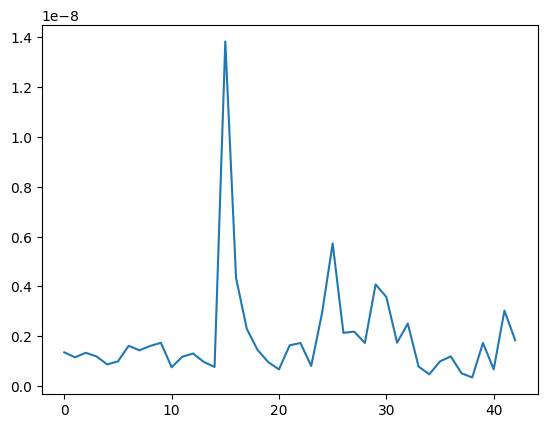

In [25]:
moment_rolling(rt10_trunc.fillna(0), order=2).plot()

#### Returns Auto

In [ ]:
show_simple_autocorr(rt1_trunc, max_lag=10)

Simple autocorrelation (Pearson) by lag:
lag  1:  0.0836
lag  2:  0.0422
lag  3:  0.0242
lag  4:  0.0177
lag  5:  0.0137
lag  6:  0.0147
lag  7:  0.0155
lag  8:  0.0155
lag  9:  0.0151
lag 10:  0.0180


In [ ]:
n

863996

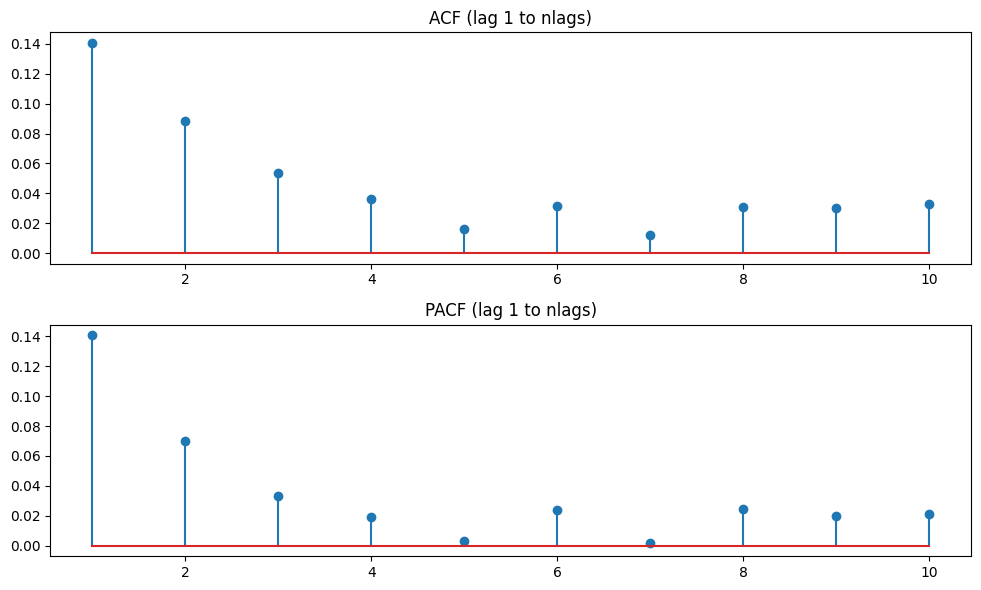

In [ ]:
plot_auto_shift(rt1_trunc.dropna()[:20000], lags=10)

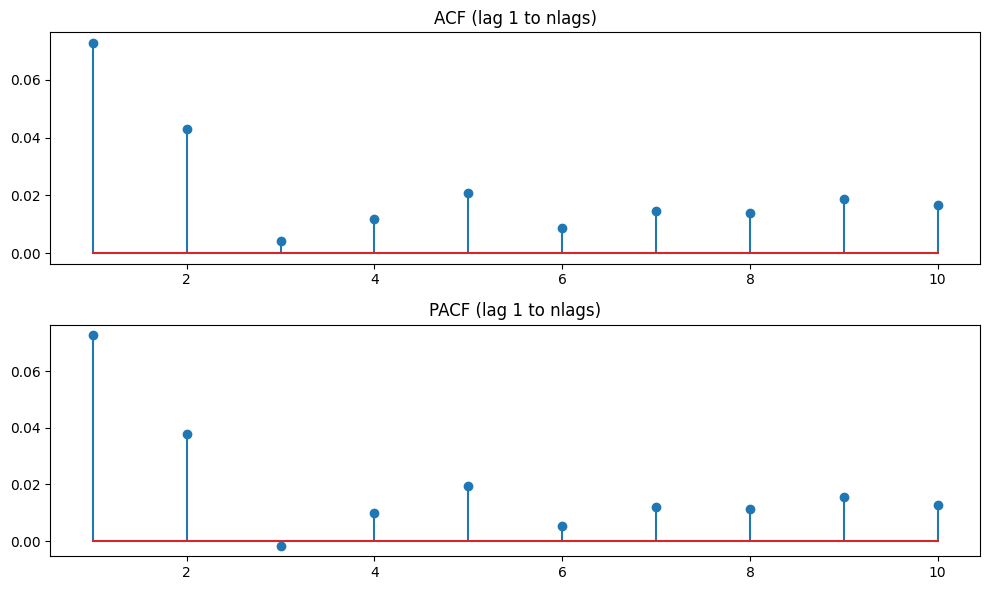

In [ ]:
plot_auto_shift(rt1_trunc.dropna()[-20000:], lags=10)

<Axes: >

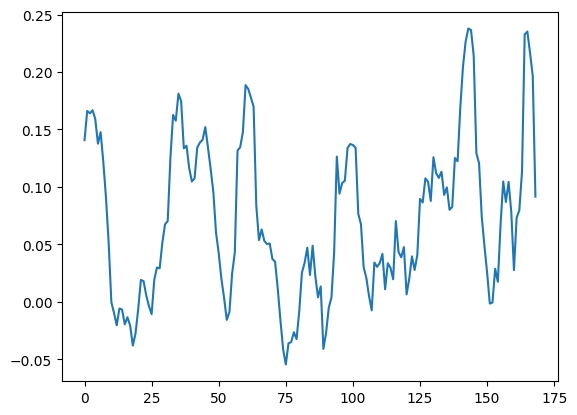

In [ ]:
acf_rolling(rt1_trunc.fillna(0), step=5000).plot()

In [ ]:
acf_rolling(rt1_trunc.fillna(0), step=5000).mean()

np.float64(0.07197209034609361)

In [ ]:
arcs = np.zeros(10)
for lag in range(1, 11):
  arcs[lag-1] = acf_rolling(rt1_trunc.fillna(0), lag=lag, window=20000, step=5000).mean()

<Axes: >

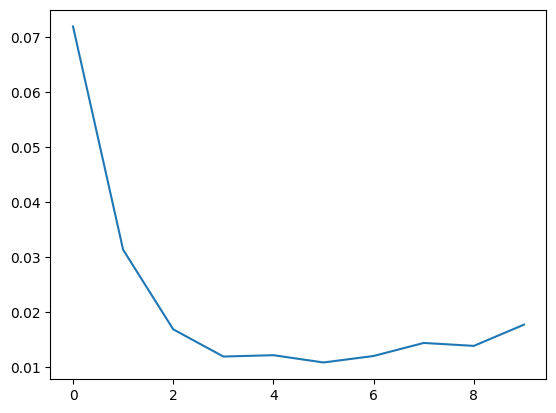

In [ ]:
pd.Series(arcs).plot()

<Axes: >

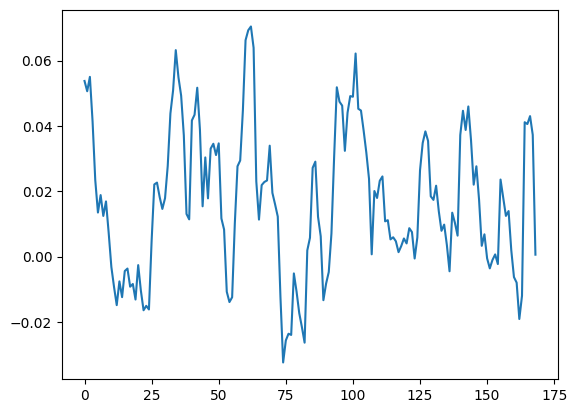

In [ ]:
acf_rolling(rt1_trunc.fillna(0), lag=3, window=20000, step=5000).plot()

#### Returns Auto Lag 10

In [ ]:
show_simple_autocorr(rt10_trunc, max_lag=10, step=10)

Simple autocorrelation (Pearson) by lag:
lag  1:  0.1065
lag  2:  0.0389
lag  3:  0.0100
lag  4:  0.0163
lag  5:  0.0080
lag  6:  0.0152
lag  7:  0.0030
lag  8:  0.0048
lag  9:  0.0103
lag 10:  0.0188


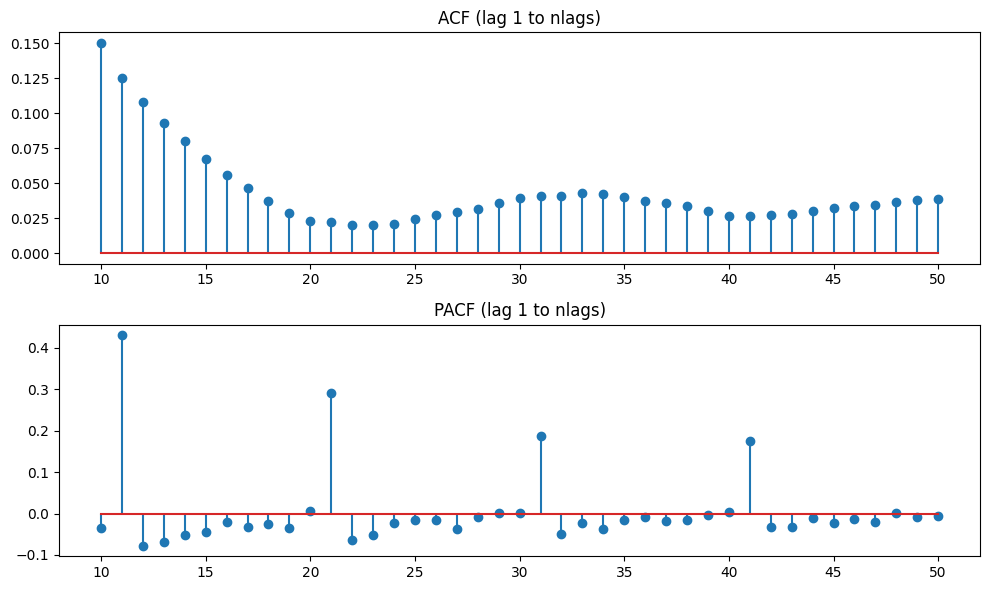

In [ ]:
plot_auto_shift(rt10_trunc[:20000], lags=50, shift=10)

<Axes: >

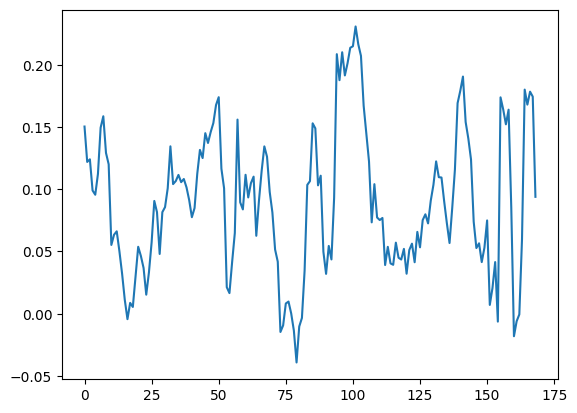

In [ ]:
acf_rolling(rt10_trunc, lag=10, step=5000).plot()

In [ ]:
arcs = np.zeros(10)
for lag in range(10, 101, 10):
  arcs[lag//10 - 1] = acf_rolling(rt10_trunc, lag=lag, window=20000, step=5000).mean()

<Axes: >

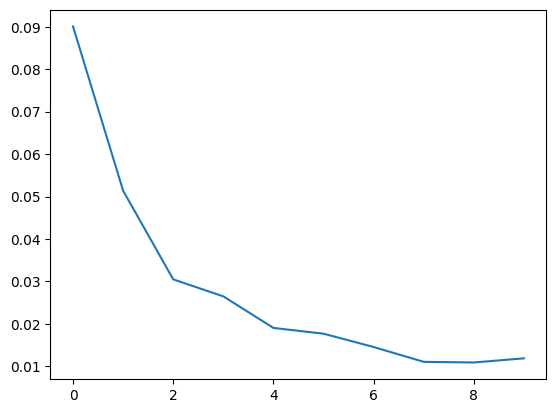

In [ ]:
pd.Series(arcs).plot()

<Axes: >

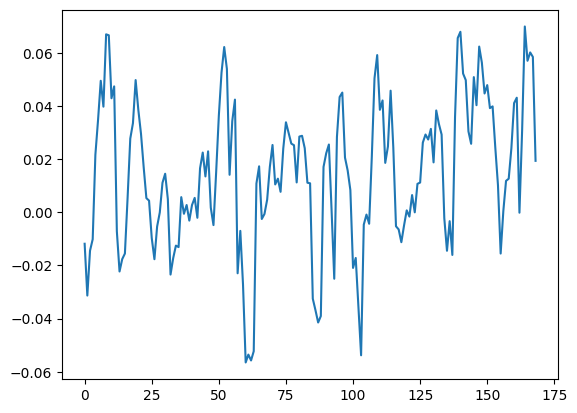

In [ ]:
acf_rolling(rt10_trunc, lag=70, step=5000).plot()

#### Volatility

#### Volume

<Axes: >

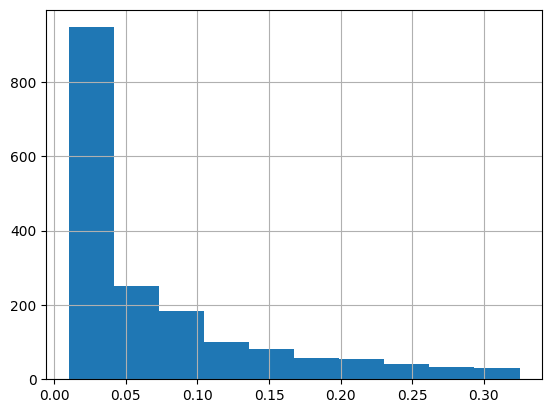

In [ ]:
quantile = 0.9
bvols = bs.buy_volume[bs.buy_volume > 1e-2]
n1 = bvols.shape[0]
bvols = bvols.sort_values()[:int(n1*quantile)]
bvols.hist()

<Axes: >

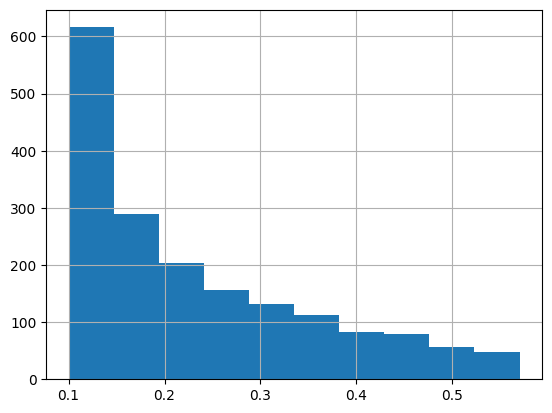

In [ ]:
np.sqrt(bvols).hist()

<Axes: >

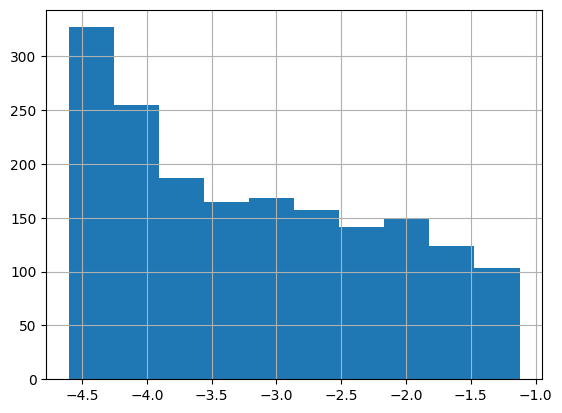

In [ ]:
np.log(bvols).hist()

In [ ]:
bs.buy_volume.corr(rt1.shift(-1))

np.float64(0.11645818804822161)

In [ ]:
bs.buy_volume.corr(rt10.shift(-1))

np.float64(0.06256516465998598)

In [ ]:
bs.sell_volume.corr(rt1.shift(-1))

np.float64(-0.13934890962132548)

In [ ]:
bs.vwap.diff().corr(rt1.shift(-1))

np.float64(0.06149736019852387)

#### VWAP

<Axes: >

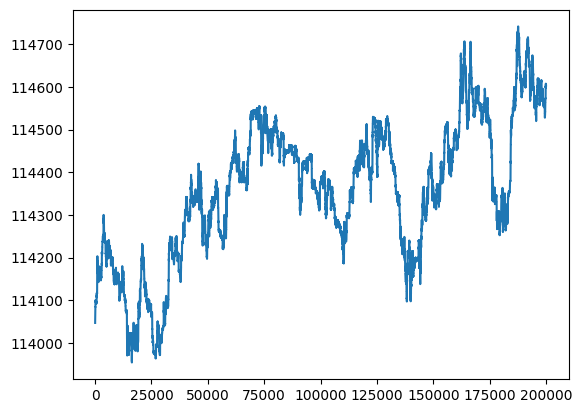

In [ ]:
bs.vwap.plot()

# Idle

In [ ]:
while True:
  1+1

KeyboardInterrupt: 